# ELEC 4727/5727 Final Exam Project - Object Detection 


# Imports

In [45]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import glob

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [46]:
import warnings
warnings.filterwarnings('ignore')

# This is needed since the notebook is stored in the object_detection folder.
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Model preparation 

## Variables : 4 per model (MODEL_NAME, PATH_TO_LABELS, NUM_CLASSES), 4th is PATH_TO_GRAPH_PB_FILE

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [47]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_GRAPH_PB_FILE = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Load information

## 1- frozen Tensorflow model into detection graph

## 2- category_index  label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [68]:
def generate_tf_graph(frozen_file_path):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
       od_graph_def = tf.GraphDef()
       with tf.gfile.GFile(frozen_file_path, 'rb') as fid:
           serialized_graph = fid.read()
           od_graph_def.ParseFromString(serialized_graph)
           tf.import_graph_def(od_graph_def, name='')
           return detection_graph
        
def generate_category_index(path_to_labels, number_classes):
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return category_index
    
detection_graph = generate_tf_graph(PATH_TO_GRAPH_PB_FILE)

category_index = generate_category_index(PATH_TO_LABELS,NUM_CLASSES)

# Detection Support Routines

In [69]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)  #default is 0.5
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

def generate_inference_visual_results(inference_graph, test_image_path_list, category_index):
    
    if len(test_image_path_list) > 101:  #call top ten
        print ('Do not visualize large list of images in Python Notebook')
        return
    
    # Size, in inches, of the output images.
    IMAGE_SIZE = (12, 8)
    for image_path in test_image_path_list[:1]:   # Visualizing only top 10
        print (image_path)
        # generate numpy image
        image_np = load_image_into_numpy_array(Image.open(image_path))
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        output_dict = run_inference_for_single_image(image_np, inference_graph)
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            line_thickness=8)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)
        
def generate_inference_results_dictionary(inference_graph, test_image_path_list):
    output_result_dict = dict()
    for image_path in test_image_path_list:
        print ('Running inferernece on ' + image_path)
        # Generate numpy image 
        image_np = load_image_into_numpy_array(Image.open(image_path))
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        output_dict = run_inference_for_single_image(image_np, inference_graph)
        output_result_dict[image_path] = output_dict
    return output_result_dict

# Image test

In [70]:
'''# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
TEST_IMAGES_DIR = 'test_images'  #change this to final data ()
TEST_IMAGE_PATHS = [ os.path.join(TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]#change this os and note take only a few images like 3 to visualize
print(TEST_IMAGE_PATHS)
'''
TEST_IMAGES_DIR = '/home/mohammedfarazalifnu/CV_FinalExam/FinalData'
#TEST_IMAGES_DIR = '/CV_FinalExam/FinalData'  #does not work
TEST_IMAGE_PATHS=[]
for dirpath, dirnames, filenames in os.walk(TEST_IMAGES_DIR):
    for filename in filenames:
        TEST_IMAGE_PATHS.append(os.path.join(dirpath, filename))

# Generate visual inference view

/home/mohammedfarazalifnu/CV_FinalExam/FinalData/SPP-2-H-04_000356.JPG


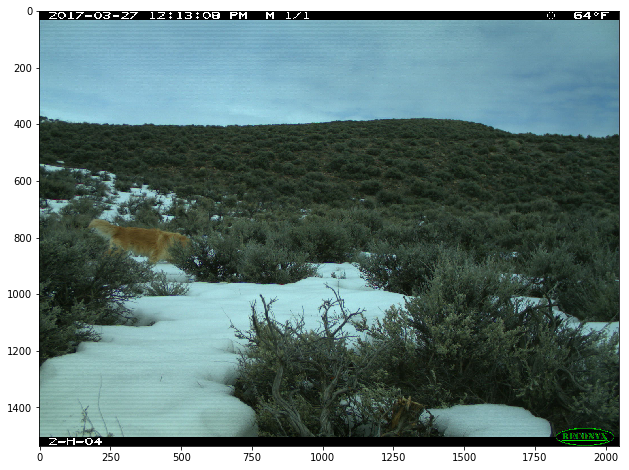

In [71]:
generate_inference_visual_results(detection_graph, TEST_IMAGE_PATHS, category_index)    

# Generate result arrays of inferences : classes and scores

In [80]:
#output_result_dict = generate_inference_results_dictionary(detection_graph, TEST_IMAGE_PATHS)
output_result_dict = generate_inference_results_dictionary(detection_graph, ["/home/mohammedfarazalifnu/CV_FinalExam/FinalData/SPP-2-H-04_000356.JPG"])
#print (category_index)
#for image_path in ["/home/mohammedfarazalifnu/CV_FinalExam/FinalData/SPP-2-H-04_000356.JPG"]:
my_result={}
print(output_result_dict)

for image_path in output_result_dict:
    print (image_path)
    x=image_path.split("/")[-1]
    print(x)
    detection_classes = output_result_dict[image_path]['detection_classes']
    my_result[x] = {i:list(detection_classes).count(i) for i in list(detection_classes)}
    print(my_result)
    
    detection_scores = output_result_dict[image_path]['detection_scores']
    print (detection_classes)
    print (detection_scores)
    


Running inferernece on /home/mohammedfarazalifnu/CV_FinalExam/FinalData/SPP-2-H-04_000356.JPG
{'/home/mohammedfarazalifnu/CV_FinalExam/FinalData/SPP-2-H-04_000356.JPG': {'detection_boxes': array([[4.70803708e-01, 9.81575400e-02, 6.10928178e-01, 2.91097820e-01],
       [4.70803708e-01, 9.81575400e-02, 6.10928178e-01, 2.91097820e-01],
       [4.66822267e-01, 5.84539771e-03, 9.76383090e-01, 3.95002455e-01],
       [4.88124043e-01, 0.00000000e+00, 9.87272143e-01, 4.10247326e-01],
       [6.88318849e-01, 1.77123845e-02, 9.82505441e-01, 3.81256312e-01],
       [7.89415717e-01, 1.89526379e-01, 9.97059703e-01, 3.71065676e-01],
       [4.89193588e-01, 7.36256018e-02, 6.59056902e-01, 2.90697426e-01],
       [4.37772483e-01, 5.58499992e-03, 8.25214982e-01, 2.59862721e-01],
       [4.71506715e-01, 1.03465073e-01, 5.45155287e-01, 1.83791965e-01],
       [3.94923061e-01, 5.31135127e-02, 6.26464486e-01, 2.59974718e-01],
       [3.87716472e-01, 0.00000000e+00, 6.58784091e-01, 1.31139308e-01],
       [

In [103]:
CPW_animal_class_dict = dict()
CPW_animal_class_dict[1] = 'person'
CPW_animal_class_dict[16] = 'bird'
CPW_animal_class_dict[17] = 'cat'
CPW_animal_class_dict[18] = 'dog'
CPW_animal_class_dict[19] = 'horse'
CPW_animal_class_dict[20] = 'sheep'
CPW_animal_class_dict[21] = 'cow'
CPW_animal_class_dict[23] = 'bear'

CPW_animal_list = ['person','bird','cat','dog','horse','sheep','cow','bear']


In [123]:
'''
classes = [1,16,17,18,19,20,21,23]
print("\n\n\n/n/n")
for image_path in output_result_dict:
    #dict2 = {x:output_result_dict[image_path]['detection_classes'][x] for x in classes}
    dict2 = {x:output_result_dict[image_path]['detection_classes'][x] for x in classes}
print(dict2) 
'''
'''
for image_path in output_result_dict:
    for i in output_result_dict[image_path]['detection_classes']:
        if i in (1,16,17,18,19,20,21,23):
'''     
#output_result_dict = generate_inference_results_dictionary(detection_graph, TEST_IMAGE_PATHS)
output_result_dict = generate_inference_results_dictionary(detection_graph, ["/home/mohammedfarazalifnu/CV_FinalExam/FinalData/SPP-2-H-04_000356.JPG"])
#print (category_index)
#for image_path in ["/home/mohammedfarazalifnu/CV_FinalExam/FinalData/SPP-2-H-04_000356.JPG"]:
my_result={}
my_prediction={}
#print(output_result_dict)

thresh_score=0.3
for image_path in output_result_dict:
    print (image_path)
    x=image_path.split("/")[-1]
    print(x)
    detection_classes = output_result_dict[image_path]['detection_classes']
    detection_scores = output_result_dict[image_path]['detection_scores']
    argval=np.argwhere(detection_scores>thresh_score)
    
    classesFound=[]
    argFound=[]
    replace_classesFound=[]
    
    for i in range(0,len(argval)):
        if detection_classes[argval[i][0]] in list(CPW_animal_class_dict.keys()):
            classesFound.append(detection_classes[argval[i][0]])
            argFound.append(argval[i][0])
    
    print("Classes Found: ", classesFound)
    print("Number of Animal Found Found: ", len(classesFound))
    #replace_classesFound = ["bear" if x == 23 else None for x in classesFound]
    for i in classesFound:
        replace_classesFound.append(CPW_animal_class_dict[i])
    
    if not replace_classesFound:  #if list is empty
        replace_classesFound.append("NONE")
    print("Replaced Classes Found: ", replace_classesFound)
    
    my_result[x] = {i:list(classesFound).count(i) for i in list(classesFound)}
    my_prediction[x]=replace_classesFound
    print(my_result)
    print( my_prediction)


Running inferernece on /home/mohammedfarazalifnu/CV_FinalExam/FinalData/SPP-2-H-04_000356.JPG
/home/mohammedfarazalifnu/CV_FinalExam/FinalData/SPP-2-H-04_000356.JPG
SPP-2-H-04_000356.JPG
Classes Found:  [23]
Number of Animal Found Found:  1
Replaced Classes Found:  ['bear']
{'SPP-2-H-04_000356.JPG': {23: 1}}
{'SPP-2-H-04_000356.JPG': ['bear']}


In [107]:
CPW_animal_class_dict = dict()
CPW_animal_class_dict[1] = 'person'
CPW_animal_class_dict[16] = 'bird'
CPW_animal_class_dict[17] = 'cat'
CPW_animal_class_dict[18] = 'dog'
CPW_animal_class_dict[19] = 'horse'
CPW_animal_class_dict[20] = 'sheep'
CPW_animal_class_dict[21] = 'cow'
CPW_animal_class_dict[23] = 'bear'

CPW_animal_list = ['person','bird','cat','dog','horse','sheep','cow','bear']


# This cell creates the "answer key" for what the human detected in the images

In [54]:
#This would be my true labels
animal_key_file = '/home/CV/FinalExam/CPW_AnimalKeyFile.txt'
animal_array = np.loadtxt(animal_key_file, skiprows=1, delimiter=',', dtype=str)

imagefile_answer_key_dict = dict()
for row in animal_array:
    imagefile_answer_key_dict[row[0]] = row[1]
    
# Example: query the image name

#print (imagefile_answer_key_dict['SPP-1-H-03_000553.JPG']) #this is old
#print (imagefile_answer_key_dict['SPP-3-L-06_001482.JPG'])

print (imagefile_answer_key_dict['SPP-2-H-04_000356.JPG'])  #This is truth value

dog


# code needed for confusion matrix

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score



# Write code to scan all files in directory FinalData